In [27]:
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
API_KEY = "BKN1BTHQ5FFGSB6NVEZV2FRX18PA8TSJSK"  
ADDRESS = "0xf60095e686e0c2Ae955B017a427DEf4F3b4Aa329"  # replace with target wallet
MAX_RECORDS = 100 

In [3]:
url = (
    f"https://api.etherscan.io/api?module=account&action=txlist"
    f"&address={ADDRESS}&startblock=0&endblock=99999999"
    f"&page=1&offset={MAX_RECORDS}&sort=asc&apikey={API_KEY}"
)

In [9]:
response = requests.get(url)
data = response.json()

In [11]:
if data["status"] != "1" or "result" not in data:
    print("⚠️  No transactions found or API error:", data.get("message", "Unknown error"))
    exit()

In [15]:
txs = data["result"]

In [19]:
processed = []
for tx in txs:
    try:
        processed.append({
            "hash": tx["hash"],
            "block": tx["blockNumber"],
            "from": tx["from"],
            "to": tx["to"],
            "value (ETH)": int(tx["value"]) / 1e18,
            "gas used": int(tx["gasUsed"]),
            "gas price (Gwei)": int(tx["gasPrice"]) / 1e9,
            "tx fee (ETH)": (int(tx["gasUsed"]) * int(tx["gasPrice"])) / 1e18,
            "timestamp": datetime.utcfromtimestamp(int(tx["timeStamp"])).strftime('%Y-%m-%d %H:%M:%S'),
            "success": tx["isError"] == "0",
        })
    except Exception as e:
        print(f"⚠️ Error processing tx {tx.get('hash')}: {e}")

/var/folders/cs/p50086m97m1d54jkbjqgggh80000gn/T/ipykernel_16216/1305489779.py:13: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(int(tx["timeStamp"])).strftime('%Y-%m-%d %H:%M:%S'),


In [25]:
if processed:
    df = pd.DataFrame(processed)
    df.to_csv("/Users/ivyadiele/Desktop/PythonProject/EtherscanScraper/data/etherscan_transactions.csv", index=False)
    print("✅ Saved to etherscan_transactions.csv")
else:
    print("⚠️ No transactions processed.")

✅ Saved to etherscan_transactions.csv


In [29]:
ether = pd.read_csv("/Users/ivyadiele/Desktop/PythonProject/EtherscanScraper/data/etherscan_transactions.csv")

ether.head()

,hash,block,from,to,value (ETH),gas used,gas price (Gwei),tx fee (ETH),timestamp,success
0,0x244962fde16969e3ec5a1d4d3e31306ce8e656acef61...,21116733,0xd3a7accc8a12af3a397d37b6e81a8b15e3cda50d,0xf60095e686e0c2ae955b017a427def4f3b4aa329,0.039000,21000,9.784455,0.000205,2024-11-04 20:40:35,True
1,0xe56ffc0d88ecbcacc25db1fc6f3b123e6f3205d41399...,21116912,0xf4d87fd6de898ad7f5ca219a9f8389ee3280395c,0xf60095e686e0c2ae955b017a427def4f3b4aa329,0.031718,21000,6.424406,0.000135,2024-11-04 21:16:23,True
2,0xb616fba820cca8ff83105e52c5a9fdd55dd75fda5e7b...,21116939,0xf60095e686e0c2ae955b017a427def4f3b4aa329,0x1231deb6f5749ef6ce6943a275a1d3e7486f4eae,0.068227,183911,5.666467,0.001042,2024-11-04 21:21:47,True
3,0x5329292427be051283e2d6078a3aff982388aa99fee2...,21123073,0x1251518f10bfa74759b1e46510e9a5fb076d0c8a,0xf60095e686e0c2ae955b017a427def4f3b4aa329,0.075000,21000,15.832242,0.000332,2024-11-05 17:54:59,True
4,0x53550627d0eafd40725ce3dd77f6ecc9a4ca62b31bb8...,21123077,0xf60095e686e0c2ae955b017a427def4f3b4aa329,0x1231deb6f5749ef6ce6943a275a1d3e7486f4eae,0.071703,183935,11.507117,0.002117,2024-11-05 17:55:47,True


In [35]:
ether["timestamp"] = pd.to_datetime(ether["timestamp"])
ether["date"] = ether["timestamp"].dt.date

In [31]:
total_fees = ether["tx fee (ETH)"].sum()
print(f"Total gas fees paid: {total_fees:.4f} ETH")

Total gas fees paid: 0.0353 ETH


In [33]:
ether["to"].value_counts().head(10)

to
0xf60095e686e0c2ae955b017a427def4f3b4aa329    19
0x1231deb6f5749ef6ce6943a275a1d3e7486f4eae    10
0x1251518f10bfa74759b1e46510e9a5fb076d0c8a     7
0x0000000000001ff3684f28c67538d4d072c22734     3
0xb330de798dcdc3a2f29cea4307defed2e4a63238     2
0xdac17f958d2ee523a2206206994597c13d831ec7     2
0xf4d87fd6de898ad7f5ca219a9f8389ee3280395c     1
0x9cf0ed013e67db12ca3af8e7506fe401aa14dad6     1
0x0bc51935db6a2940a8898ea0852a7e22890da84e     1
Name: count, dtype: int64

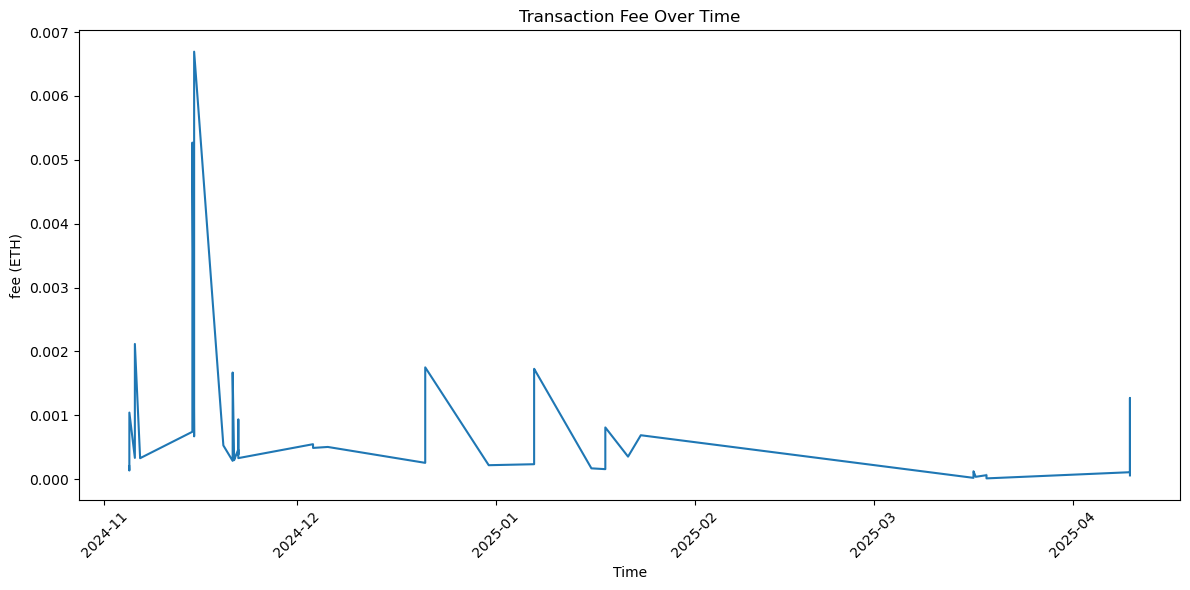

In [39]:
plt.figure(figsize=(12, 6))
sns.lineplot(data = ether, x="timestamp", y="tx fee (ETH)")
plt.title("Transaction Fee Over Time")
plt.ylabel("fee (ETH)")
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

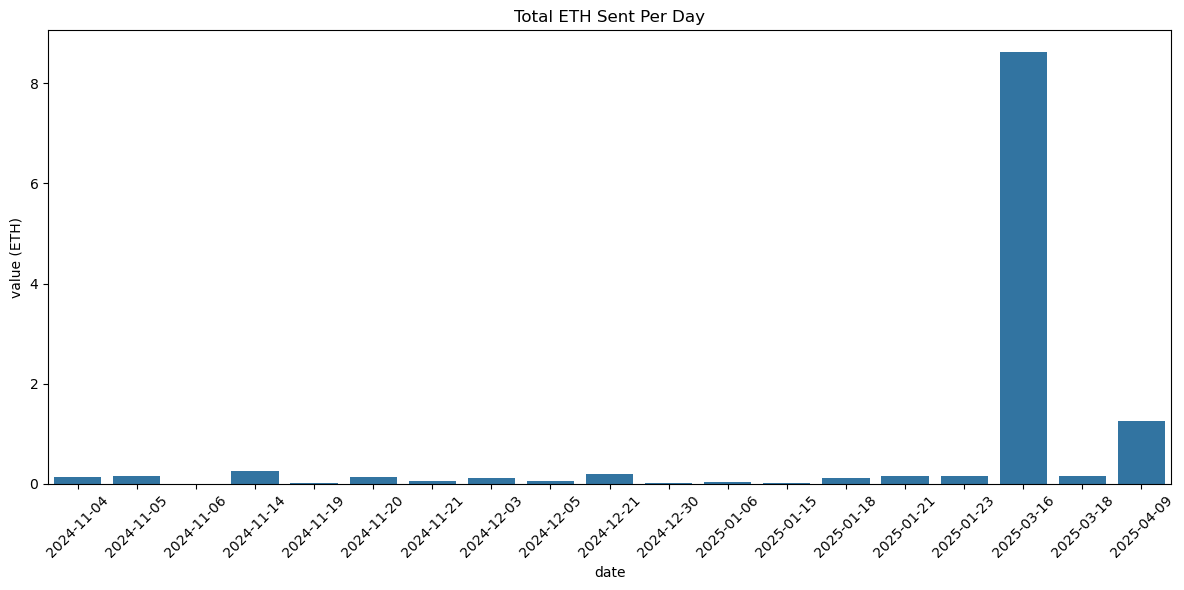

In [41]:
eth_daily = ether.groupby("date")["value (ETH)"].sum().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=eth_daily, x="date", y="value (ETH)")
plt.title("Total ETH Sent Per Day")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

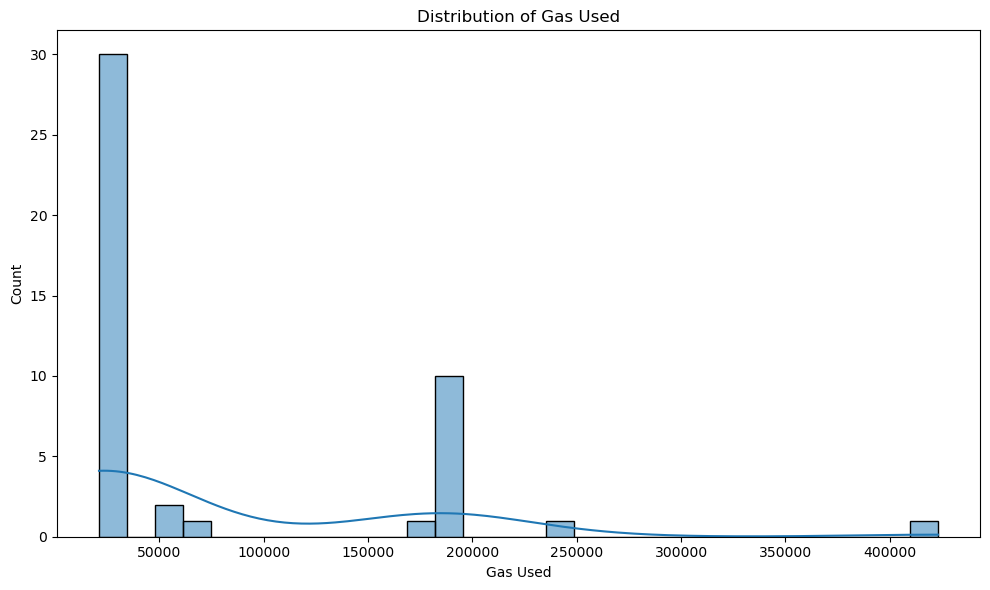

In [43]:
plt.figure(figsize=(10,6))
sns.histplot(ether["gas used"], bins=30, kde=True)
plt.title("Distribution of Gas Used")
plt.xlabel("Gas Used")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

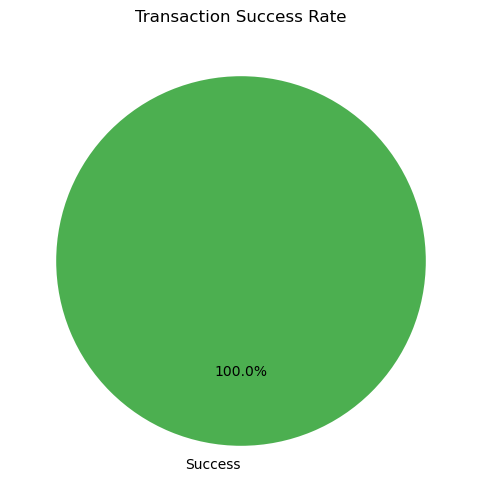

In [45]:
plt.figure(figsize=(6,6))
ether["success"].value_counts().plot.pie(
    labels=["Success", "Failed"],
    autopct='%1.1f%%',
    startangle=90,
    colors=["#4CAF50", "#FF5722"]
)
plt.title("Transaction Success Rate")
plt.ylabel("")
plt.show()